## 使用NER&Denpendency Prasing对句子进行解析 

### 句子依存关系解析

分析步骤：
1. 把文章切断成句子
2. 对条句子进行分析

In [1]:
from sqlalchemy import Column, String, create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.sql import select

In [2]:
passward = '###'
host = '###'
user = 'root'
post = '3306'
database = 'stu_db'
engine= create_engine("mysql+mysqlconnector://{}:{}@{}:{}/{}".format(user,passward,host,post,database))
connection = engine.connect()

In [3]:
id_list = connection.execute("select id from news_chinese")
id_list = id_list.fetchall()
content_list = connection.execute("select content from news_chinese")
content_list = content_list.fetchall()

命名实体识别标注集:
- 标记 =	含义
- O =	这个词不是NE
- S =	这个词单独构成一个NE
- B =	这个词为一个NE的开始
- I =	这个词为一个NE的中间
- E =	这个词位一个NE的结尾
- Nh =	人名
- Ni =	机构名
- Ns =	地名

用依存句法分析找出观点的内容，以下代码是测试时候方便调试的代码

In [1]:
from pyltp import Segmentor
from pyltp import Postagger
from pyltp import NamedEntityRecognizer
from pyltp import SentenceSplitter
from pyltp import Parser
import os

#分句
def cut_sentence(string):
    """@string contain many sentence"""
    from pyltp import SentenceSplitter
    sents = SentenceSplitter.split(string)  # 分句
    return list(sents)
    
#分词
def cut_word(sentence,model):
    """@sentence is a string"""
    words = model.segment(sentence)  # 分词
    return list(words)

#词信标注
def pos_label(words, mdoel):
    """@words is a list result of cut word"""
    postags = mdoel.postag(words)  # 词性标注
    return list(postags)

#命名实体识别
def ner_label(words, postags, model):
    """@words is a list  result of cut word
       @postags is a list result of Part-Of-Speech tagging
    """
    netags = model.recognize(words, postags)  # 命名实体识别
    return list(netags)

#依存句法分析
def dependency_parsing(words, postags, model):
    """@words is a list  result of cut word
       @postags is a list result of Part-Of-Speech tagging
    """ 
    arcs = model.parse(words, postags)  # 句法分析
    return list(arcs)

def find_word_index(word,words):
    for i in range(len(words)):
        if words[i] == word:
            return i
def find_head(den_parsing_list):
    for i in range(len(den_parsing_list)):
        if den_parsing_list[i].head == 0:
            return i

def search_index(start, den_parsing_list,word_list):
    tree_dict = {word_list[start]:{}}
    j=0
    for i,arc in enumerate(den_parsing_list):
        if arc.head == start+1:
            j +=1
            tree_dict[word_list[start]][word_list[i]] = \
            search_index(i,den_parsing_list,word_list)
    if j==0:return word_list[start]
    return tree_dict  

from collections import defaultdict
#该函数找出树形结构关系，并返回关系，层数和最大宽度，方便图绘制
def search_find_dict(start, den_parsing_list,word_list_orgin):
    word_list = []
    #对重复词进行重新编号，以区别
    for i,word in enumerate(word_list_orgin):
        if word in word_list:
            word_list.append(word+'_'+str(i))
        else:
            word_list.append(word)
            
    tree_dict = defaultdict(list)
    
    current_layer = 0
    length = len(start)
    max_length = 0
    while start!= []:
        current_p = start.pop(0)
        length -= 1 
        for i,arc in enumerate(den_parsing_list):
            if arc.head == current_p+1:
                start.append(i)
                tree_dict[word_list[current_p]] += [[word_list[i],arc.relation]]
        #当遍历到下一层时
        if length == 0:
            current_layer +=1
            length = len(start)
            if max_length < length:
                max_length = length
    return tree_dict

In [2]:
def pretty_print(word_list, ner_list):   
    import math
    num = math.ceil(len(word_list)/14)
    index = range(1, len(word_list)+1)
    for line_num in range(num):
        str1 = ''
        str2 = ''
        str3 = ''
        if line_num == num -1:
            word_temp = word_list[line_num*14:]
            ner_temp = ner_list[line_num*14:]
            index_temp = index[line_num*14:]
        else:
            word_temp = word_list[line_num*14:(line_num+1)*14]
            ner_temp = ner_list[line_num*14:(line_num+1)*14]   
            index_temp = index[line_num*14:(line_num+1)*14]
        for i, j in zip(word_temp, ner_temp):
            i_len = len(i)
            j_len = len(j)
            if i_len > 5:
                str1 += '{}\t|'
                str2 += '{}\t\t|'
                str3 += '{}\t\t|'
            else:
                str1 += '{}\t|'
                str2 += '{}\t|'
                str3 += '{}\t|'
        print(str3.format(*index_temp))
        print(str1.format(*word_temp))
        print(str2.format(*ner_temp),'\n')
      

In [3]:
from matplotlib import pyplot as plt

In [4]:
plt.rcParams['font.sans-serif']= ['SimHei']

自定义个绘制了依存句法关系的模块：

模块在plottree.plottree 里的 createPlot方法

去掉标点，对比一下结果

### 针对说等次词，找出其宾语即说的内容

In [4]:
#输入显示调整函数
def pretty_print(word_list, ner_list):   
    import math
    num = math.ceil(len(word_list)/14)
    index = range(1, len(word_list)+1)
    for line_num in range(num):
        str1 = ''
        str2 = ''
        str3 = ''
        if line_num == num -1:
            word_temp = word_list[line_num*14:]
            ner_temp = ner_list[line_num*14:]
            index_temp = index[line_num*14:]
        else:
            word_temp = word_list[line_num*14:(line_num+1)*14]
            ner_temp = ner_list[line_num*14:(line_num+1)*14]   
            index_temp = index[line_num*14:(line_num+1)*14]
        for i, j in zip(word_temp, ner_temp):
            i_len = len(i)
            j_len = len(j)
            if i_len > 5:
                str1 += '{}\t|'
                str2 += '{}\t\t|'
                str3 += '{}\t\t|'
            else:
                str1 += '{}\t|'
                str2 += '{}\t|'
                str3 += '{}\t|'
        print(str3.format(*index_temp))
        print(str1.format(*word_temp))
        print(str2.format(*ner_temp),'\n')
        
def table_print(word_list, ner_list):
    import prettytable as pt
    tb = pt.PrettyTable()
    tb.add_column('1',word_list)
    tb.add_column('2',ner_list)
    print(tb)

In [5]:
import gc
gc.collect()

11

In [164]:
##完成项目代码
from collections import defaultdict
from pyltp import Segmentor
from pyltp import Postagger
from pyltp import NamedEntityRecognizer
from pyltp import SentenceSplitter
from pyltp import Parser
from gensim.models import KeyedVectors
import numpy as np
import jieba
import os
import time
from collections import Counter

def get_sentences_vec(model_wv, sent_list, word_frequence):
    # 句子向量化处理
    a = 0.001
    row = model_wv.vector_size
    col = len(sent_list)
    sent_mat = np.zeros((row, col))
    for i, sent in enumerate(sent_list):
        length = len(sent)
        sent_vec = np.zeros(row)
        for word in sent:
            pw = word_frequence[word]
            w = a / (a + pw)
            try:
                vec = np.array(model_wv[word])
                sent_vec += w * vec
            except:
                pass
        sent_mat[:, i] += sent_vec
        sent_mat[:, i] /= length

    # PCA处理
    sent_mat = np.mat(sent_mat)
    u, s, vh = np.linalg.svd(sent_mat)
    sent_mat = sent_mat - u * u.T * sent_mat
    return sent_mat

def get_word_frequence(words):
    #这里不做停用次处理，直接在计算句子向量时候，如果找不到该词，直接跳过
    word_list = []
    for word in words:
        word_list += word
    word_frequence = Counter(word_list)
    return word_frequence

# 计算余弦相似度
def cos_similarity(v1, v2):
    #输入向量维度不一致
    if len(v1) != len(v2):
        return 0
    return np.vdot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# 返回句子向量矩阵中各列向量与第一列向量的相似度
def calcu_similarity(sent_mat):
    #采用点积的方法计算
    first = np.array(sent_mat[:, 0]).flatten()
    col = sent_mat.shape[1]
    sims = []
    for i in range(1, col):
        vec = np.array(sent_mat[:, i]).flatten()
        sims.append(cos_similarity(first, vec))
    return sims

#获取相似度结果
def get_similarity_result(word_list_all, model_wv):
    word_frequence = get_word_frequence(word_list_all)
    sent_mat = get_sentences_vec(model_wv, word_list_all,word_frequence)
    sim = calcu_similarity(sent_mat)
    return sim

#分句
def cut_sentence(string):
    """@string contain many sentence"""
    from pyltp import SentenceSplitter
    sents = SentenceSplitter.split(string)  # 分句
    return list(sents)

def load_all_model():
    """返回分词，词性标注，命名实体识别，依存解析等实例对象"""
    LTP_DATA_DIR = 'E:/MYGIT/Project/ltp_data'  # ltp模型目录的路径
    cws_model_path = os.path.join(LTP_DATA_DIR, 'cws.model')  # 分词模型路径，模型名称为`cws.model`
    segmentor = Segmentor()  # 初始化实例
    segmentor.load_with_lexicon(cws_model_path, '../ltp_data/cut_external_dict/cut_external_dict')  # 加载模型
    
    LTP_DATA_DIR = 'E:/MYGIT/Project/ltp_data'  # ltp模型目录的路径
    pos_model_path = os.path.join(LTP_DATA_DIR, 'pos.model')  # 词性标注模型路径，模型名称为`pos.model`
    postagger = Postagger() # 初始化实例
    postagger.load_with_lexicon(pos_model_path, '../ltp_data/pos_external_dict/pos_external_dict')  # 加载模型

    LTP_DATA_DIR = 'E:/MYGIT/Project/ltp_data'  # ltp模型目录的路径
    ner_model_path = os.path.join(LTP_DATA_DIR, 'ner.model')  # 命名实体识别模型路径，模型名称为`pos.model`
    recognizer = NamedEntityRecognizer() # 初始化实例
    recognizer.load(ner_model_path)  # 加载模型

    LTP_DATA_DIR = 'E:/MYGIT/Project/ltp_data'  # ltp模型目录的路径
    par_model_path = os.path.join(LTP_DATA_DIR, 'parser.model')  # 依存句法分析模型路径，模型名称为`parser.model`   
    parser = Parser() # 初始化实例
    parser.load(par_model_path)  # 加载模型
    
    fname = r"E:/MYGIT/model/wiki_stopwords/wiki_word2vec.kv"
    #model_wv.save(fname)
    model_wv = KeyedVectors.load(fname, mmap='r')
    return [segmentor, postagger, recognizer, parser,model_wv]

def release_all_model(model_list):
    del(model_list[-1])
    for each in model_list:
        each.release()

#获取人名或机构名
def get_name(word_list, prase, ner_list, pos_list,say_index):
    # 合并说话对象名字
    index = -1
    for arc in prase:
        if arc.relation == "SBV" and arc.head == say_index + 1:
            index = prase.index(arc)
            #break
            # 第二种情况
    if index == -1:
        for arc in prase:
            if arc.relation == "SBV" and arc.head == prase[say_index].head and prase[say_index].relation == "COO":
                index = prase.index(arc)
    # 两种情况都没找到
    if index == -1: return ''

    Entity = ('S-Nh', 'S-Ni', 'S-Ns','B-Nh', 'B-Ni','B-Ns', 'I-Nh', 'I-Ni','I-Ns', 'E-Nh', 'E-Ni','E-Ns')  # 命名实体标记
    #Entity = ('S-Nh', 'S-Ni')  # 命名实体标记
    name = ''
    cur = index
    ret_flag = False
    while cur >= 0:
        if ner_list[cur] in Entity or cur == index:
            name = word_list[cur] + name   
            if ner_list[cur] in Entity:ret_flag = True
            cur -= 1
        else:
            break

    if ret_flag:return name
    if pos_list[index] not in ('n', 'nh', 'ws'): return ''
    
    pre = word_list[:index]  # 前半部分
    pos = word_list[index + 1:]  # 后半部分
    while pre:
        w = pre.pop(-1)
        w_index = word_list.index(w)
        # if prase[w_index].relation == 'ADV': continue
        if prase[w_index].relation in ('WP', 'ATT', 'SVB') and (w not in ('，','。','、','）','（')):
            name = w + name
        else:
            pre = False
    while pos:
        w = pos.pop(0)
        w_index = word_list.index(w)
        if prase[w_index].head - 1 == index or \
                prase[prase[w_index].head - 1].head - 1 == index or \
                prase[prase[prase[w_index].head - 1].head - 1].head - 1 == index:
            if prase[w_index].relation in ('WP', 'LAD', 'COO', 'RAD', 'ATT') and w_index < say_index and (
                    w not in ('，', '。', '、', '）', '（')):
                name = name + w  # 向后拼接
            else:  # 中断拼接直接返回
                pos = False
        else:
            pos = False
    return name 
 
def get_under_node(parent_node, parse, relation):
    index = []
    for arc in parse:
        if arc.relation == relation and arc.head == parent_node +1:
            index.append(parse.index(arc))
    try:
        return index
    except NameError:
        return -1 
    
#找出输入所有节点中最小的索引和最大的索引，然后返回两者间的句子
def node_under_sentence(parent_point, den_parsing_list, word_list):    
    words_index = []
    #搜索子节点
    if parent_point == [] or parent_point[0] < 0 :return ''
    for point in parent_point:
        start = [point]
        words_index.append(start[0])
        while start!= []:
            cur = start.pop(0)
            for i, arc in enumerate(den_parsing_list):
                if arc.head == cur + 1:
                    words_index.append(i)
                    start.append(i)
    words_index = sorted(words_index)
    #print(words_index, len(word_list))
    return ''.join(word_list[words_index[0]:words_index[-1]+1])

#从文件中提取与说相关的词
def get_relatedwords():
    path  = 'E:/MYGIT/Project/NLP-Project-1/related_words/saywords'
    relatedwords_list = []
    with open(path, encoding='utf-8') as f:
        line_str= f.readline()
        while line_str  != '':
            relatedwords_list.append(line_str.strip('\n'))
            line_str = f.readline()
    relatedwords_list = tuple(relatedwords_list)
    return relatedwords_list

def find_opinion_of_someone(input_news, say_related, model_list):
    # 输入文本进行分句
    segmentor = model_list[0]
    postagger = model_list[1]
    recognizer= model_list[2]
    parser= model_list[3]
    model_wv = model_list[4]

    sentence_list = cut_sentence(input_news)
    sentence_list = [sen for sen in sentence_list if len(sen) > 3]
    Entity = ['S-Nh', 'S-Ni','B-Nh', 'B-Ni', 'I-Nh', 'I-Ni', 'E-Nh', 'E-Ni']  # 命名实体标记
    pro_news_dict = defaultdict(list) #用来存储可能是多句的句子
    news_dict = defaultdict(list)
    
    word_list_all = [list(segmentor.segment(sentence)) for sentence in sentence_list]  # 分词
    #name_list = [] #用于保存所有人名
    for _i, sentence in enumerate(sentence_list):
        #print('\n——————————句子:{} 处理过程——————————'.format(_i + 1))
        #time_point_1 = time.time()
        word_list = word_list_all[_i]  #     
        pos_list = list(postagger.postag(word_list))  # 词性分析
        ner_list = list(recognizer.recognize(word_list, pos_list))  # 命名实体提取
        den_parsing_list = list(parser.parse(word_list, pos_list))  # 依存关系
                       
        # 获取命名实体和说相关词,同时获取索引值
        pro_say_word = [(a, i) for i, a in enumerate(word_list) if a in say_related]  
        if pro_say_word==[]:continue
        
        # 找到说的主语
        for say in pro_say_word:
            if say[0] in (':','：') and den_parsing_list[say[1]].relation == 'WP':
                say = (say[0], den_parsing_list[say[1]].head-1)
            name = get_name(word_list, den_parsing_list, ner_list, pos_list, say[1])
            #print('第{}句子, sayword:{} name:{}'.format(_i, say, name))
            if name != '':
                say_underword = []
                index = get_under_node(say[1], den_parsing_list, 'VOB')           
                if index != -1: 
                    _flag = len(index)
                    say_underword += index
                    index = get_under_node(say[1], den_parsing_list, 'COO')
                    if index != -1: say_underword += index
                        
                #特殊情况处理1
                if len(say_underword) > _flag:
                    for _node in range(_flag):
                        if pos_list[say_underword[_node]] in ['n','nh']:
                            say_underword.pop(0)
                
                #特殊情况处理2
                saying = node_under_sentence(say_underword, den_parsing_list, word_list)
                if not saying:
                    if (den_parsing_list[say[1]].relation =='POB' and den_parsing_list[den_parsing_list[say[1]].head-1].relation == 'ADV'):
                        saying = ''.join(word_list[say[1]+1:])
                        saying = saying.strip('，')
                    if not saying:
                        if _i>0:
                            quotations = re.findall(r'“(.+?)”', sentence_list[_i-1])
                            if quotations and len(quotations[-1])> 6: saying = quotations[-1]
                if saying != '':
                    if saying[-5:] in sentence[-9:]:
                        words1 = jieba.lcut(saying)
                        _word_list = sentence_list[_i+1:_i+4] #切片的话_i+4如果超出则取到末尾
                        _word_list.insert(0, words1)
                        sim = get_similarity_result(_word_list, model_wv)
                        #print(sim)
                        for i_sim, _sim in enumerate(sim):
                            if _sim > 0.85:
                                pro_news_dict[_i] += [sentence_list[_i + i_sim+1]]
                            else:
                                break
                    news_dict[_i] = [name, say[0], saying]
                    break  
    
    #对多句添加进行判断，如果下一句里没说，或没提取出来，则拼接到上一句，避免重复
    for key in pro_news_dict.keys():
        for _i in range(len(pro_news_dict[key])):
            if key+_i+1 not in news_dict.keys():
                news_dict[key][1] += pro_news_dict[key][_i]
            else:
                break 
    return news_dict

以上提取程序还未解决以下特殊情况:
- line1："###########言论########"
- line2：某某说，##############

在这种情况中，line1也是某某说的话，该程序只提取到了line2后面的话

### 测试提取效果，用以改进提取算法

In [5]:
import random
import re
import os

In [6]:
list(range(4))

[0, 1, 2, 3]

In [7]:
%%time
relatedwords_list = get_relatedwords()

Wall time: 328 ms


In [8]:
#获取测试新闻
news_path = r'E:/MYGIT/DataSources/THUCNews/news_origin/社会新闻_all.txt'
news_list = []
with open(news_path, encoding='utf-8') as f:
    for i in range(10000):
        line_str = f.readline()
        if line_str == '': break
        if line_str.startswith('视频') or line_str.startswith('调查') or len(line_str)>1500: continue
        news_list.append(line_str.strip('\n'))
#news_list[:10]

In [9]:
':' in relatedwords_list

True

In [10]:
'：' in relatedwords_list

True

In [11]:
import gc
gc.collect()

0

In [12]:
model_list = load_all_model()

D:\Design Software\Anaconda\envs\py36\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [13]:
test

NameError: name 'test' is not defined

In [53]:
release_all_model(model_list)

In [12]:
test = random.choice(news_list)
test = test.replace('\u3000','')
test = test.replace('\\n','')
#test += sen
sentence_list = cut_sentence(test)

In [26]:
sen = '''IG Markets高级分析师DanCook说，“我最大的忧虑是如果消费者失业或没有钱消费，无论消费者如何乐观都变得不重要'''

In [38]:
find_opinion_of_someone(sen[1],relatedwords_list,model_list)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Oliver\AppData\Local\Temp\jieba.cache


front


Loading model cost 0.936 seconds.
Prefix dict has been built succesfully.


defaultdict(list, {0: ['其家人', '介绍', '小涛的爷爷听说用纯碱水洗酒坛很管用']})

In [186]:
for _a, i in enumerate(sentence_list):
    print('第{}句: {}'.format(_a+1, i))

第1句: 地震生死恋人将在北京台春晚完婚本报讯（记者 龙露）今天上午，北京电视台春晚总导演齐建彤宣布，从四川大地震中走出来的一对新人贺晨曦、郑广明将在春节联欢晚会上举行他们的婚礼。
第2句: 上午，海淀区新贵大厦二层大宅门餐厅内红灯高挂、北侧的小舞台上布满了鲜花，一对由数百朵红玫瑰组成的两颗“心形”花环紧紧重叠在一起。
第3句: 11时，在《童话》悠扬的音乐声中，一对新人贺晨曦、郑广明踏着红地毯穿过花门走上舞台，举行了订婚仪式，新娘贺晨曦身穿蓝色晚礼服，脸上洋溢着幸福的笑容。
第4句: 在场的志愿者对新人表达了真情的祝福，餐厅的220名服务员每人捐出了一元钱表达了220个对新人的祝福。
第5句: 据介绍，准新郎郑广明来自东北，到四川打工时认识了四川姑娘贺晨曦。
第6句: 在四川大地震时，贺晨曦被压在废墟下104个小时。
第7句: 当她被救出后，一直昏迷不醒，见此，郑广明不断对她呼唤：你快醒来吧，醒来，我们马上结婚。
第8句: 在郑广明爱的呼唤下，贺晨曦终于脱离了危险。
第9句: 大地震后，家没了，工作也没了，两人只好挤在一间几平方米的小屋内，仅靠郑广明打工赚到的一点钱维持生计，结婚却成了两人暂时无法完成的一个“梦”。
第10句: 北京电视台《真情耀中华》栏目的工作人员得知这个情况后，号召志愿者及所有北京市民共同帮助贺晨曦、郑广明完成这个婚礼。
第11句: 12月10日，志愿者从北京出发了。
第12句: 15日，两人被接到了北京，北京的志愿者不但为两人定好下榻的酒店，还帮他们定好了订婚的餐厅。
第13句: 更多的北京市民打来电话，愿意为两人提供婚车、礼服。
第14句: 北京电视台春节联欢晚会总导演齐建彤介绍，贺晨曦、郑广明的正式婚礼要在大年三十的春晚联欢会上举办，我们要为这对新人举办一场盛大的婚礼。
第15句: 此外，齐建彤还透露，《真情耀中华》栏目的明星志愿者——电影演员刘烨通过栏目组转来了为新人祝福的红包。
第16句: 孙妍 摄


In [43]:
#sentence_list

In [19]:
#该模块是自己编写的，为了方便观察依存关系树
from plottree import plottree

In [173]:
sen = ['IG Markets高级分析师DanCook说，“我最大的忧虑是如果消费者失业或没有钱消费，无论消费者如何乐观都变得不重要',
'''据其家人介绍，小涛的爷爷听说用纯碱水洗酒坛很管用''',
'''李某某称，其销售的生羊合格。''',
'''单霁翔再次重申：“中国政府高度重视和关心流失海外中国文物的问题''',
'''单霁翔说，中国文物流失时间跨度较大''',
      '中共中央总书记习近平表示，要加强基础建设',
      '据合肥一些玩家透露，目前，我省淮南、淮北一带的一些煤老板也投身“石海”。他们动辄花上百万、千万从一些个人玩家手上收集玉器',
      '虚幻引擎3动作游戏《黑光》新作公布曾经开发过多款大受好评电脑军事游戏的美国Zombie Studios公司，日前宣布与福克斯电影合作']

In [174]:
#word_list = cut_word(sentence_list[0], model_list[0])
word_list = cut_word(sen[-1], model_list[0])
pos_list = pos_label(word_list, model_list[1])
ner_list = ner_label(word_list,pos_list,model_list[2])
den_parsing_list = dependency_parsing(word_list,pos_list,model_list[3])
dp_list = [str(arc.head) + ':'+ arc.relation for arc in den_parsing_list]

In [175]:
pretty_print(word_list, ner_list)
#pretty_print(word_list, pos_list)

1	|2	|3	|4	|5	|6	|7	|8	|9	|10	|11	|12	|13	|14	|
虚幻引擎	|3	|动作	|游戏	|《	|黑光	|》	|新作	|公布	|曾经	|开发	|过	|多	|款	|
O	|O	|O	|O	|O	|O	|O	|O	|O	|O	|O	|O	|O	|O	| 

15	|16	|17	|18	|19	|20	|21	|22	|23		|24		|25	|26	|27	|28	|
大	|受	|好评	|电脑	|军事	|游戏	|的	|美国	|Zombie	|Studios	|公司	|，	|日前	|宣布	|
O	|O	|O	|O	|O	|O	|O	|B-Ni	|I-Ni		|I-Ni		|E-Ni	|O	|O	|O	| 

29	|30	|31	|32	|
与	|福克斯	|电影	|合作	|
O	|S-Nh	|O	|O	| 



In [178]:
get_name(word_list, den_parsing_list, ner_list, pos_list, 26)

''

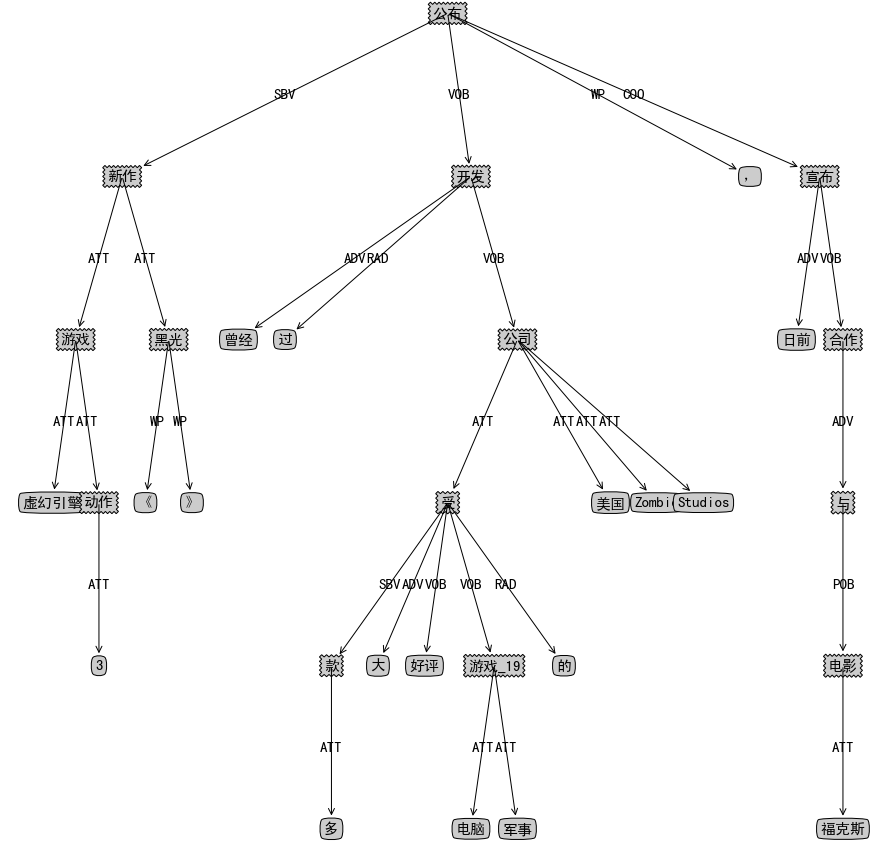

In [177]:
relation_dict = search_find_dict([find_head(den_parsing_list)],den_parsing_list, word_list)
start = word_list[find_head(den_parsing_list)]
plottree.createPlot(start, relation_dict)

## 确定言论结束

Sentence Embedding-基础词向量的句子向量化处理

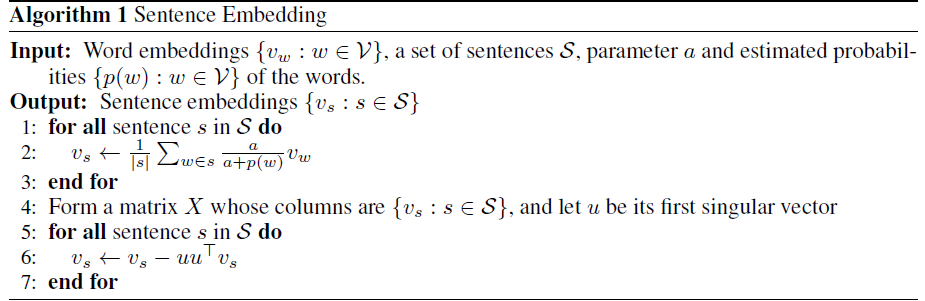

- line2：计算每条句子的向量，以列存储 原文是 compute the weighted average of the word vector
- line6：原文是 remove the projections of the average vectors on their first singular verctor(common component removal),至于为什么line6这样计算会是common component removal，还没弄明白，有空再深究
- 最后得到的矩阵是M×N的 M为词向量维度，N为句子个数，可以看出每个句子向量都是以列保存的

In [2]:
fname = r"E:/MYGIT/model/wiki_stopwords/wiki_word2vec.kv"
#model_wv.save(fname)
model_wv = KeyedVectors.load(fname, mmap='r')

D:\Design Software\Anaconda\envs\py36\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [57]:
from gensim.models import KeyedVectors
import logging

#该函数对应的是上诉图片中伪代码的实现过程
def get_sentences_vec(model_wv, sent_list, word_frequence):
    # 句子向量化处理
    a = 0.001
    row = model_wv.vector_size
    col = len(sent_list)
    sent_mat = np.zeros((row, col))
    for i, sent in enumerate(sent_list):
        length = len(sent)
        sent_vec = np.zeros(row)
        for word in sent:
            pw = word_frequence[word]
            w = a / (a + pw)
            try:
                vec = np.array(model_wv[word])
                sent_vec += w * vec
            except:
                pass
        sent_mat[:, i] += sent_vec
        sent_mat[:, i] /= length

    # PCA处理
    sent_mat = np.mat(sent_mat)
    u, s, vh = np.linalg.svd(sent_mat)
    sent_mat = sent_mat - u * u.T * sent_mat
    return sent_mat

def get_word_frequence(words):
    #这里不做停用次处理，直接在计算句子向量时候，如果找不到该词，直接跳过
    word_list = []
    for word in words:
        word_list += word
    word_frequence = Counter(word_list)
    return word_frequence

# 计算余弦相似度
def cos_similarity(v1, v2):
    #输入向量维度不一致
    if len(v1) != len(v2):
        return 0
    return np.vdot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# 返回句子向量矩阵中各列向量与第一列向量的相似度
def calcu_similarity(sent_mat):
    #采用点积的方法计算
    first = np.array(sent_mat[:, 0]).flatten()
    col = sent_mat.shape[1]
    sims = []
    for i in range(1, col):
        vec = np.array(sent_mat[:, i]).flatten()
        sims.append(cos_similarity(first, vec))
    return sims

#获取相似度结果
def get_similarity_result(word_list_all, model_wv):
    word_frequence = get_word_frequence(word_list_all)
    sent_mat = get_sentences_vec(model_wv, word_list_all,word_frequence)
    sim = calcu_similarity(sent_mat)
    return sim

## 使用Flask等web框架展示项目成果